# LSUN Bedrooms

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

from diffusers.models import AutoencoderKL
from fastcore.foundation import L
from fastprogress import progress_bar
from PIL import Image
import torchvision.transforms.functional as TF,torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.io import read_image, ImageReadMode
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.diffusion import *
from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.fid import *

In [ ]:
set_seed(1103, False)
logging.disable(logging.WARNING)

## Data Processing

In [ ]:
data_dir = Path("data")
data_dir.mkdir(exist_ok=True)
data_path = data_dir / "bedroom.tgz"
url = 'https://s3.amazonaws.com/fast-ai-imageclas/bedroom.tgz'

In [ ]:
if not data_path.exists():
    fc.urlsave(url, data_path)
    shutil.unpack_archive(data_path, data_dir)

In [ ]:
!ls data/bedroom/0/0/0

000038527b455eaccd15e623f2e229ecdbceba2b.jpg
00012e7f370296610a118b1a939906f8011c1a6d.jpg
000408a4d4f3563abf4c3fe16cef57d0ec4922a5.jpg
00067aee03b47f0757897c774b36e66e4d126a00.jpg
0006e7ed3650794b844a976d39b11069f9eee7a6.jpg
000771d1d30bca531888ae96d133cd4b8969c2a5.jpg
000c3cbbd295fcd21994b49eb5ca69e7ef821714.jpg
000cc33c422f7e0ae2434617ceb7199e059342f6.jpg


In [ ]:
img = read_image("./data/bedroom/0/0/0/000038527b455eaccd15e623f2e229ecdbceba2b.jpg")
img.shape, img.min(), img.max()

(torch.Size([3, 256, 341]),
 tensor(0, dtype=torch.uint8),
 tensor(255, dtype=torch.uint8))

In [ ]:
TF.center_crop(img, 256).shape

torch.Size([3, 256, 256])

In [ ]:
class BedroomDS:
    def __init__(self, path):
        self.filepaths = list(map(str, path.glob("**/*.jpg")))

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, i):
        image = read_image(self.filepaths[i], mode=ImageReadMode.RGB)
        return TF.center_crop(image, 256).to(dtype=torch.float32) / 255.

In [ ]:
bedroom_ds = BedroomDS(data_dir / "bedroom")

In [ ]:
img = bedroom_ds[1]
img.shape, img.min(), img.max()

(torch.Size([3, 256, 256]), tensor(0.), tensor(1.))

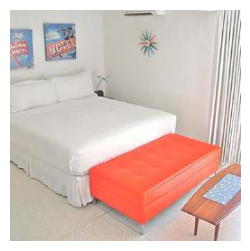

In [ ]:
show_image(img, figsize=(3,3));

In [ ]:
bs = 16
dl = DataLoader(bedroom_ds, batch_size=bs, num_workers=4)
xb = next(iter(dl))

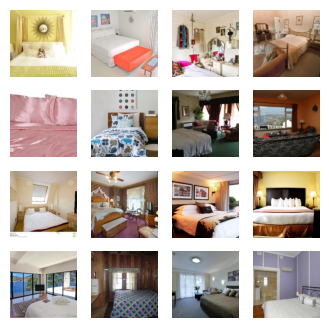

In [ ]:
show_images(xb[:16], imsize=1);

## VAE

In [ ]:
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema").requires_grad_(False).cuda()

In [ ]:
latents = vae.encode(xb[:16].cuda())

In [ ]:
type(latents)

diffusers.models.modeling_outputs.AutoencoderKLOutput

In [ ]:
xb[:16].shape, latents.latent_dist.mean.shape

(torch.Size([16, 3, 256, 256]), torch.Size([16, 4, 32, 32]))

In [ ]:
latents = latents.latent_dist.mean

In [ ]:
latents.min(), latents.max()

(tensor(-32.5178, device='cuda:0'), tensor(30.5821, device='cuda:0'))

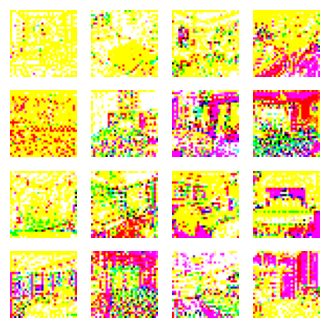

In [ ]:
show_images(latents[:, :3], imsize=1);

In [ ]:
decoded = vae.decode(latents)["sample"]

In [ ]:
decoded.min(), decoded.max()

(tensor(-0.4199, device='cuda:0'), tensor(1.2037, device='cuda:0'))

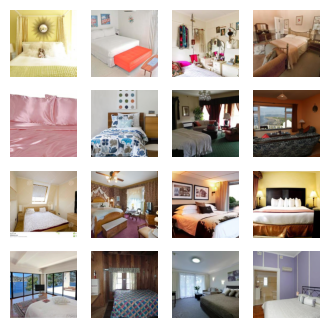

In [ ]:
show_images(decoded.clamp(0, 1), imsize=1);

In [ ]:
mmf_path = data_dir / "bedroom" / "latents.dat"

In [ ]:
# mmf_shape = (len(bedroom_ds), *latents.shape[1:])
mmf_shape = (303125, 4, 32, 32)
mmf_shape

(303125, 4, 32, 32)

In [ ]:
if not mmf_path.exists():
    mmf = np.memmap(mmf_path, dtype='float32', mode='w+', shape=mmf_shape)
    cur = 0
    for i, xb in enumerate(progress_bar(dl)):
        cur_bs = len(xb)
        next = cur + cur_bs
        with torch.no_grad():
            mmf[cur:next] = to_cpu(vae.encode(xb.cuda()).latent_dist.mean).numpy()
        cur = next
    mmf.flush()
    del mmf

In [ ]:
mmf_latents = np.memmap(mmf_path, dtype="float32", mode="r", shape=mmf_shape)

## Noisify

In [ ]:
bs = 64

In [ ]:
xb = mmf_latents[:10000].copy()

In [ ]:
xb.min(), xb.max(), xb.mean(), xb.std()

(-54.71969, 58.334755, 1.6829399, 4.9029884)

In [ ]:
mmf_latents.shape

(303125, 4, 32, 32)

In [ ]:
xb /= 5
xb.min(), xb.max(), xb.mean(), xb.std()

(-10.943937, 11.666951, 0.3365883, 0.98059803)

In [ ]:
import numpy as np

In [ ]:
def collate_ddpm(b):
    b = np.array(b)
    b = add_noise(default_collate(b) * 0.2)
    return b

In [ ]:
n = len(mmf_latents)
train_size = int(0.9 * n)
val_size = n - train_size

train_lats = mmf_latents[:train_size]
val_lats = mmf_latents[train_size:]
train_size, val_size

(272812, 30313)

In [ ]:
train_lats.min(), train_lats.max()

(-56.011936, 58.334755)

In [ ]:
dls = DataLoaders(
    DataLoader(train_lats, batch_size=bs, collate_fn=collate_ddpm, num_workers=4, shuffle=True),
    DataLoader(val_lats, batch_size=bs, collate_fn=collate_ddpm, num_workers=4, shuffle=False)
)

In [ ]:
xb, yb = next(iter(dls.train))

In [ ]:
xb[0].min(), xb[0].max(), xb[0].mean(), xb[0].std()

(tensor(-6.0812), tensor(6.8685), tensor(0.2236), tensor(1.0063))

In [ ]:
yb.min(), yb.max(), yb.mean(), yb.std()

(tensor(-5.0089), tensor(4.8311), tensor(-0.0018), tensor(1.0008))

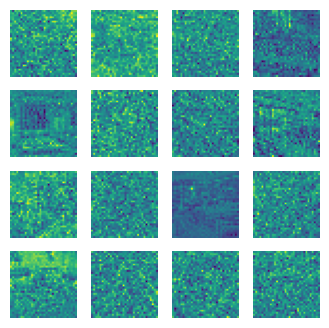

In [ ]:
show_images(xb[0][:16, 0], imsize=1);

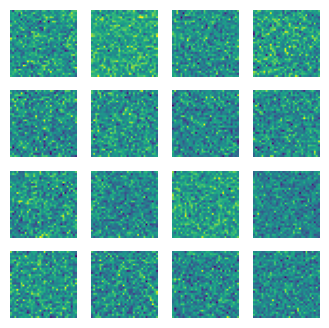

In [ ]:
show_images(yb[:16, 0], imsize=1);

In [ ]:
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB()]
opt_func = partial(optim.AdamW, eps=1e-4)

In [ ]:
def init_ddpm(m):
    for b in m.down:
        for l in b.layers:
            l.convs[-1][-1].weight.data.zero_()

    for b in m.up:
        for l in b.blocks:
            l.convs[-1][-1].weight.data.zero_()

    return m

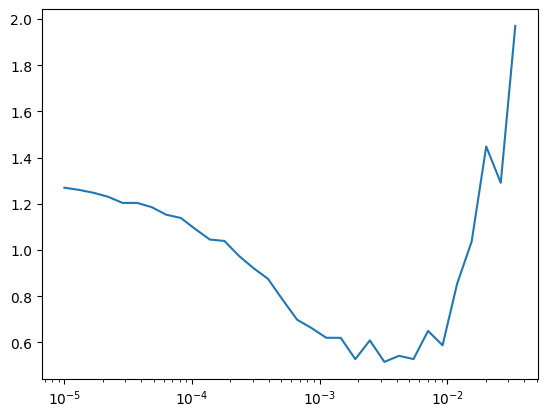

In [ ]:
set_seed(1103, False)
TrainLearner(
    init_ddpm(EmbUNetModel(in_channels=4, out_channels=4, nfs=(32, 64, 128, 256), num_layers=2, attn_channels=32)),
    dls, F.mse_loss, lr=0.1, cbs=[DeviceCB()], opt_func=opt_func
).lr_find()

loss,epoch,train
0.330,0,train
0.290,0,valid
0.286,1,train
0.281,1,valid
0.278,2,train
0.274,2,valid
0.275,3,train
0.428,3,valid
0.272,4,train
0.270,4,valid


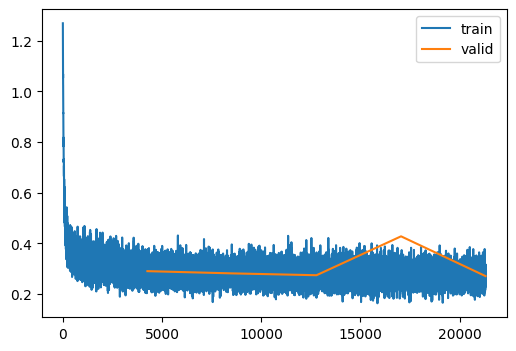

In [ ]:
set_seed(1103, False)
lr = 0.001
epochs = 5
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))
cbs = [DeviceCB(), ProgressCB(True), MetricsCB(), sched]

model = init_ddpm(EmbUNetModel(in_channels=4, out_channels=4, nfs=(32, 64, 128, 256), num_layers=2, attn_channels=32))

opt_func = partial(optim.AdamW, eps=1e-4)

learn = TrainLearner(model, dls, F.mse_loss, lr=lr, cbs=cbs, opt_func=opt_func)
learn.fit(epochs)

In [ ]:
model_path = Path("models")
model_path.mkdir(exist_ok=True)
torch.save(learn.model, model_path / "30_lsun_diffusion-latents_5.pkl")

## Sampling

In [ ]:
model_path = Path("models")
model = torch.load(model_path / "30_lsun_diffusion-latents_5.pkl").cuda()

In [ ]:
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema").requires_grad_(False).cuda()

In [ ]:
set_seed(1103, False)
samples = sample(partial(ddim_step, clipv=10), model, (16, 4, 32, 32), 100)
samples.min(), samples.max()

(tensor(-8.5770), tensor(9.6661))

In [ ]:
samples *= 5

In [ ]:
samples.min(), samples.max()

(tensor(-42.8851), tensor(48.3307))

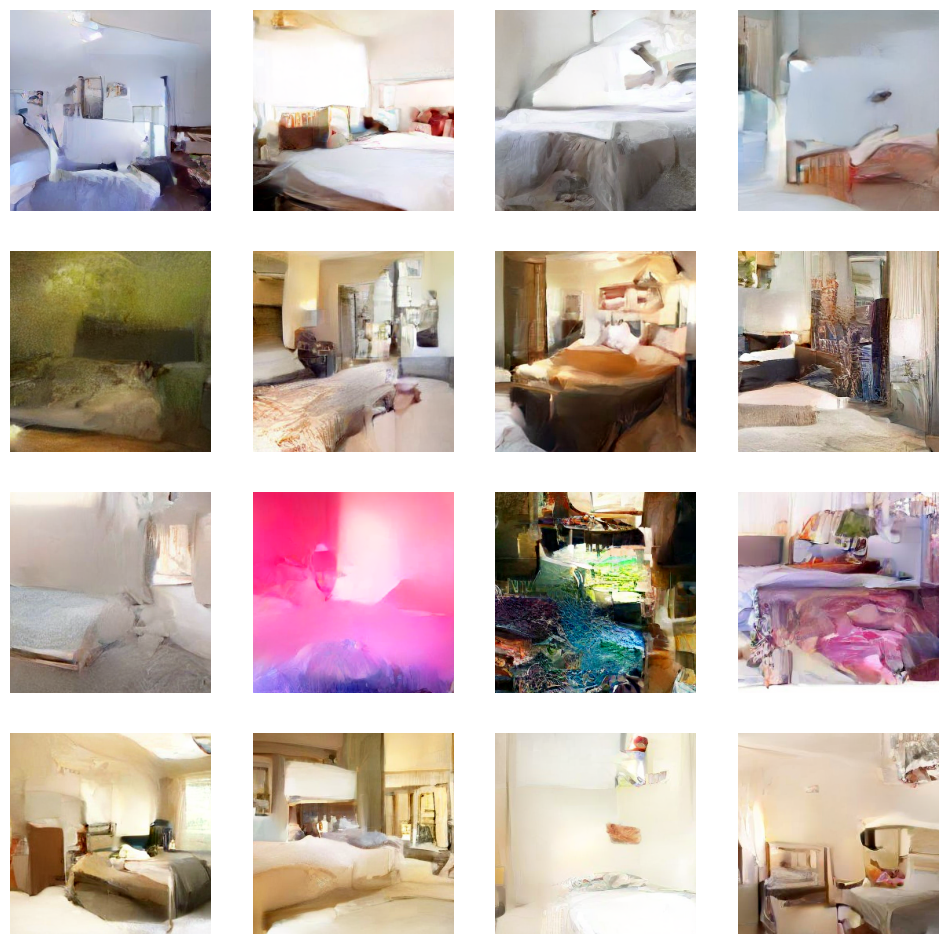

In [ ]:
decoded = vae.decode(samples.cuda())["sample"]
show_images(decoded.clamp(0, 1), imsize=3);

In [ ]:
set_seed(1103, False)
samples = sample(partial(ddim_step, clipv=10), model, (16, 4, 32, 32), 300)
samples *= 5

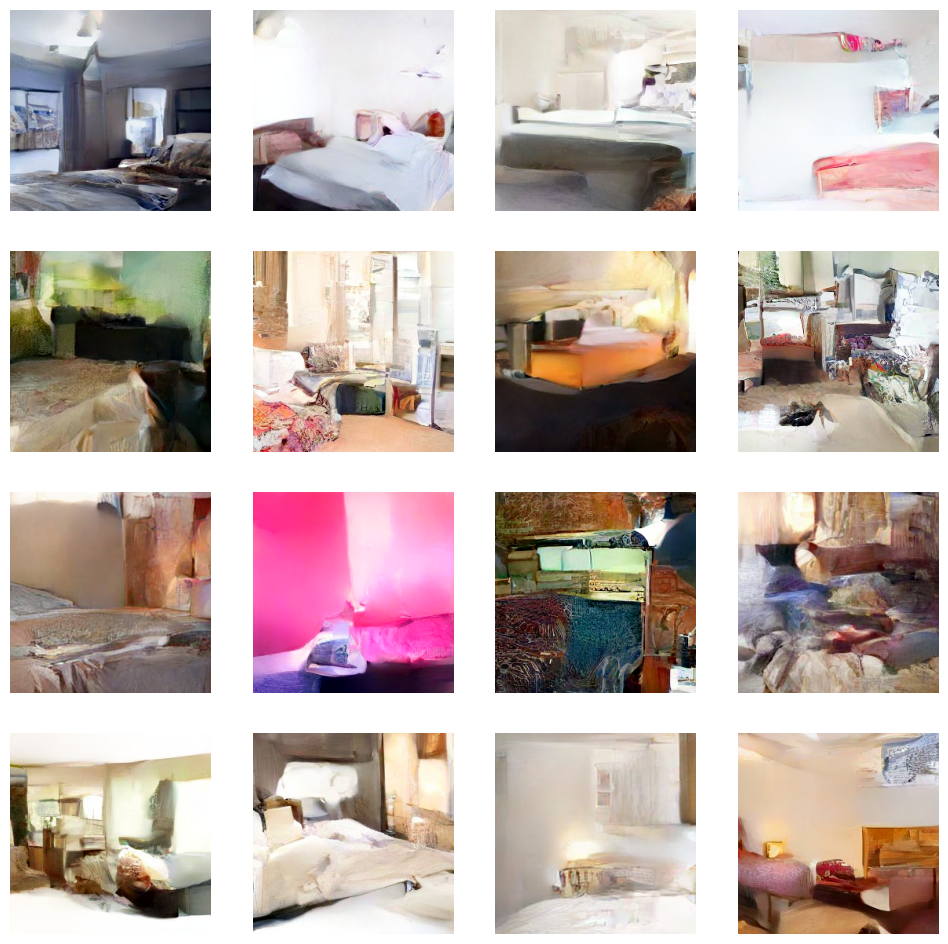

In [ ]:
decoded = vae.decode(samples.cuda())["sample"]
show_images(decoded.clamp(0, 1), imsize=3);